# Language Model trained with MLP

- Context window is 3 tokens wide.
- Much superior to Bigram.
- This implementation will be a character language model, i.e., given a sequence of characters, it will predict the next character in the sequence.

In [1]:
import torch
import math
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt

### Load 'names.txt' Dataset

In [2]:
names = open('names_all.txt', 'r').read().splitlines()
print(f"Total Names: {len(names)}", *names[:5], "...", sep=", ")

Total Names: 32033, emma, olivia, ava, isabella, sophia, ...


### Dictionaries to convert characters to int and back

In [3]:
ctoi = {c:i for i, c in enumerate(['.'] + sorted(list(set(''.join(names)))))}
itoc = {i:c for c, i in ctoi.items()}
vocab_size = len(ctoi)

### Define Block Size

It is the size of the context window. Here, 3 characters are used as it provides a good balance, according to the dataset.

In [4]:
block_size = 3

Using a rolling window to create dataset. `.` character is used as the delimiter.

In [5]:
def build_dataset(words, block_size=block_size):
    X = []
    Y = []
    for word in words:
        context = [0] * block_size
        for c in word + '.':
            ci = ctoi[c]
            X.append(context)
            Y.append(ci)
            context = context[1:] + [ci]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y


In [6]:
X, Y = build_dataset(names, block_size=block_size)

### Splitting Data into Training, Validation and Testing

- Training data proportion: 80%     [`Xtrn, Ytrn`]
- Validation data proportion: 10%   [`Xdev, Ydev`]
- Testing data proportion: 10%      [`Xtst, Ytst`]

Data is shuffled to get more accurate results when testing on Xdev / Xtst

In [7]:
trnProp = 0.8
valProp = 0.1

n1 = int(trnProp*len(names))
n2 = int((trnProp + valProp)*len(names))

random.shuffle(names)

Xtrn, Ytrn = build_dataset(names[:n1])
Xdev, Ydev = build_dataset(names[n1:n2])
Xtst, Ytst = build_dataset(names[n2:])

In [8]:
Ytrn.shape, Ydev.shape, Ytst.shape

(torch.Size([182547]), torch.Size([22809]), torch.Size([22790]))

In [9]:
from typing import Any


class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weights = torch.randn((fan_in, fan_out)) / fan_in ** 0.5
        self.bias = torch.zeros((fan_out)) if bias else None

    def __call__(self, x):
        self.out = x @ self.weights
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weights] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    '''
    esp: small value to ensure no div by zero
    training: update running mean and var only while training
    '''
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        # params
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # buffers
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        
        self.out = xhat * self.gamma + self.beta

        # update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = self.running_mean * (1-self.momentum) + xmean * self.momentum
                self.running_var = self.running_var * (1-self.momentum) + xvar * self.momentum
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    '''
    just calculates tanh
    '''
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    
dims = 15
hidden_layer = 150

C = torch.randn((vocab_size, dims))

layers = [
    Linear(dims*block_size  , hidden_layer), Tanh(),
    Linear(hidden_layer     , hidden_layer), Tanh(),
    Linear(hidden_layer     , hidden_layer), Tanh(),
    Linear(hidden_layer     , hidden_layer), Tanh(),
    Linear(hidden_layer     , hidden_layer), Tanh(),
    Linear(hidden_layer     , vocab_size)
]

with torch.no_grad():
    layers[-1].weights *= 0.1 # make last layer less confident

    # apply gain to all other layers
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weights *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # print total params
for p in parameters:
    p.requires_grad = True

101982


In [10]:
losstrn = []

In [11]:
nitr = 20000
lrs = torch.linspace(0.1, 0.001, nitr)
for g in range(nitr):
    # make minibatch
    ix = torch.randint(0, Xtrn.shape[0], (64,))
    Xb, Yb = Xtrn[ix], Ytrn[ix] # X,Y batch

    # forward pass
    emb = C[Xtrn[ix]]
    x = emb.view(emb.shape[0], -1) # concatenate vectors

    for layer in layers:
        x = layer(x)

    loss = F.cross_entropy(x, Yb)
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = lrs[g]
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if g % 1000 == 0:
        print(f'{g:7d} of {nitr:7d}: {loss.item():.4f}')
    losstrn.append(loss.log10().item())

      0 of   20000: 3.2978
   1000 of   20000: 2.3922
   2000 of   20000: 2.1830
   3000 of   20000: 2.1679
   4000 of   20000: 2.3154
   5000 of   20000: 2.2493
   6000 of   20000: 2.0664
   7000 of   20000: 2.4438
   8000 of   20000: 2.1308
   9000 of   20000: 2.2184
  10000 of   20000: 1.8062
  11000 of   20000: 2.2539
  12000 of   20000: 1.8504
  13000 of   20000: 2.0478
  14000 of   20000: 1.7790
  15000 of   20000: 1.8444
  16000 of   20000: 1.9245
  17000 of   20000: 2.1104
  18000 of   20000: 2.1276
  19000 of   20000: 2.1122


### Plot of log loss vs iterations

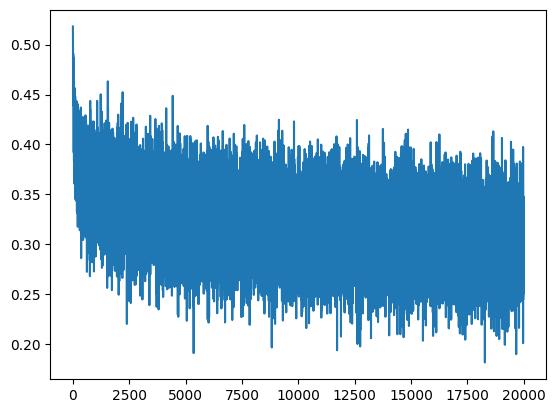

In [12]:
plt.plot(losstrn)

Function to calculate loss on given dataset

In [13]:
@torch.no_grad
def getloss(X, Y):
    emb = C[X]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Y)
    return loss

layer 1 (Tanh      ): mean +0.04, std 0.75, sat 19.37%
layer 3 (Tanh      ): mean +0.01, std 0.75, sat 17.55%
layer 5 (Tanh      ): mean -0.00, std 0.77, sat 18.55%
layer 7 (Tanh      ): mean +0.00, std 0.78, sat 19.43%
layer 9 (Tanh      ): mean +0.00, std 0.75, sat 15.66%


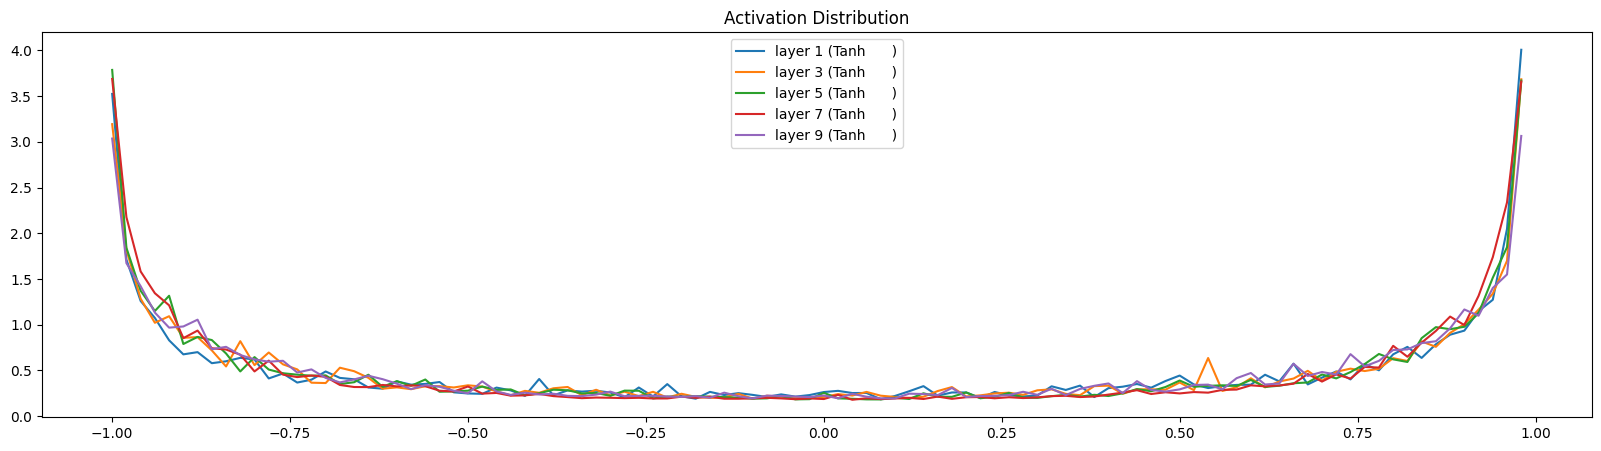

In [19]:
plt.figure(figsize=(20, 5))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print(f'layer {i} ({layer.__class__.__name__:10s}): mean {t.mean():+.2f}, std {t.std():.2f}, sat {(t.abs() > 0.97).float().mean()*100:.2f}%')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__:10s})')

plt.legend(legends)
plt.title('Activation Distribution')
plt.show()



### Print the loss on the training, validation and testing datasets

In [15]:
print(f"Training Loss: {getloss(Xtrn, Ytrn).item()}")
print(f"Validation Loss: {getloss(Xdev, Ydev).item()}")
print(f"Testing Loss: {getloss(Xtst, Ytst).item()}")

Training Loss: 2.020598888397217
Validation Loss: 2.089977502822876
Testing Loss: 2.078009843826294
